# Jupyter notebook
## Data cleaning and transformation
Three datasets are used to plot solar PV by constituency. First the merge of 'UK constituencies' with 'election results' requires some cleanup as Ordnance Survey and the House of Commons Library have different naming conventions. Then the PV location data has to be converted to a GeoDataFrame before joining to the constituencies data.

Null values only exist in columns of no interest in this analysis.

In [43]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines


In [44]:
#Load PV installations data from Open Climate Fix
pv_data = pd.read_csv('datasets/UK_PV_metadata_OCF.csv')    

#Load geospatial data from Ordnance Survey
uk_constituencies = gpd.read_file('datasets/bdline_essh_gb/Data/GB/westminster_const_region.shp')

#Load election results from the House of Commons Library
election_results = pd.read_csv('datasets/HoC-GE2019-results-by-constituency-csv.csv')

print('pv_data')
print(pv_data.isnull().sum())
print('uk_constituencies')
print(uk_constituencies.isnull().sum())
print('election_results')
print(election_results.isnull().sum())

pv_data
ss_id                 0
latitude_rounded      0
longitude_rounded     0
llsoacd               0
orientation           0
tilt                  0
kwp                   0
operational_at       36
dtype: int64
uk_constituencies
NAME            0
AREA_CODE       0
DESCRIPTIO      0
FILE_NAME       0
NUMBER          0
NUMBER0         0
POLYGON_ID      0
UNIT_ID         0
CODE            0
HECTARES        0
AREA            0
TYPE_CODE       0
DESCRIPT0       0
TYPE_COD0     632
DESCRIPT1     632
geometry        0
dtype: int64
election_results
CODE                 0
ons_region_id        0
constituency_name    0
county_name          0
region_name          0
country_name         0
constituency_type    0
mp_firstname         0
mp_surname           0
mp_gender            0
result               0
first_party          0
second_party         0
dtype: int64


In [45]:


#Clean constituency names and merge dataframes
uk_constituencies['NAME'] = uk_constituencies['NAME'].str.replace('Const', '').str.replace('Co', '').str.replace('Boro', '').str.replace('Burgh', '').str.rstrip()
election_results = election_results.rename(columns={'constituency_name': 'NAME'} )

combined = pd.merge(uk_constituencies, election_results, on='CODE', how='left')
combined['first_party'] = combined['first_party'].fillna('Unknown')
#print(combined.head())

In [46]:

geometry = gpd.points_from_xy(pv_data.longitude_rounded, pv_data.latitude_rounded)
pv_geo = gpd.GeoDataFrame(pv_data, geometry=geometry, crs='EPSG:4326')
pv_geo = pv_geo.to_crs(combined.crs)

pv_constituencies = gpd.sjoin(pv_geo, combined, predicate='within', how='left')

# Analysis
## Plotting PV installations by constituency


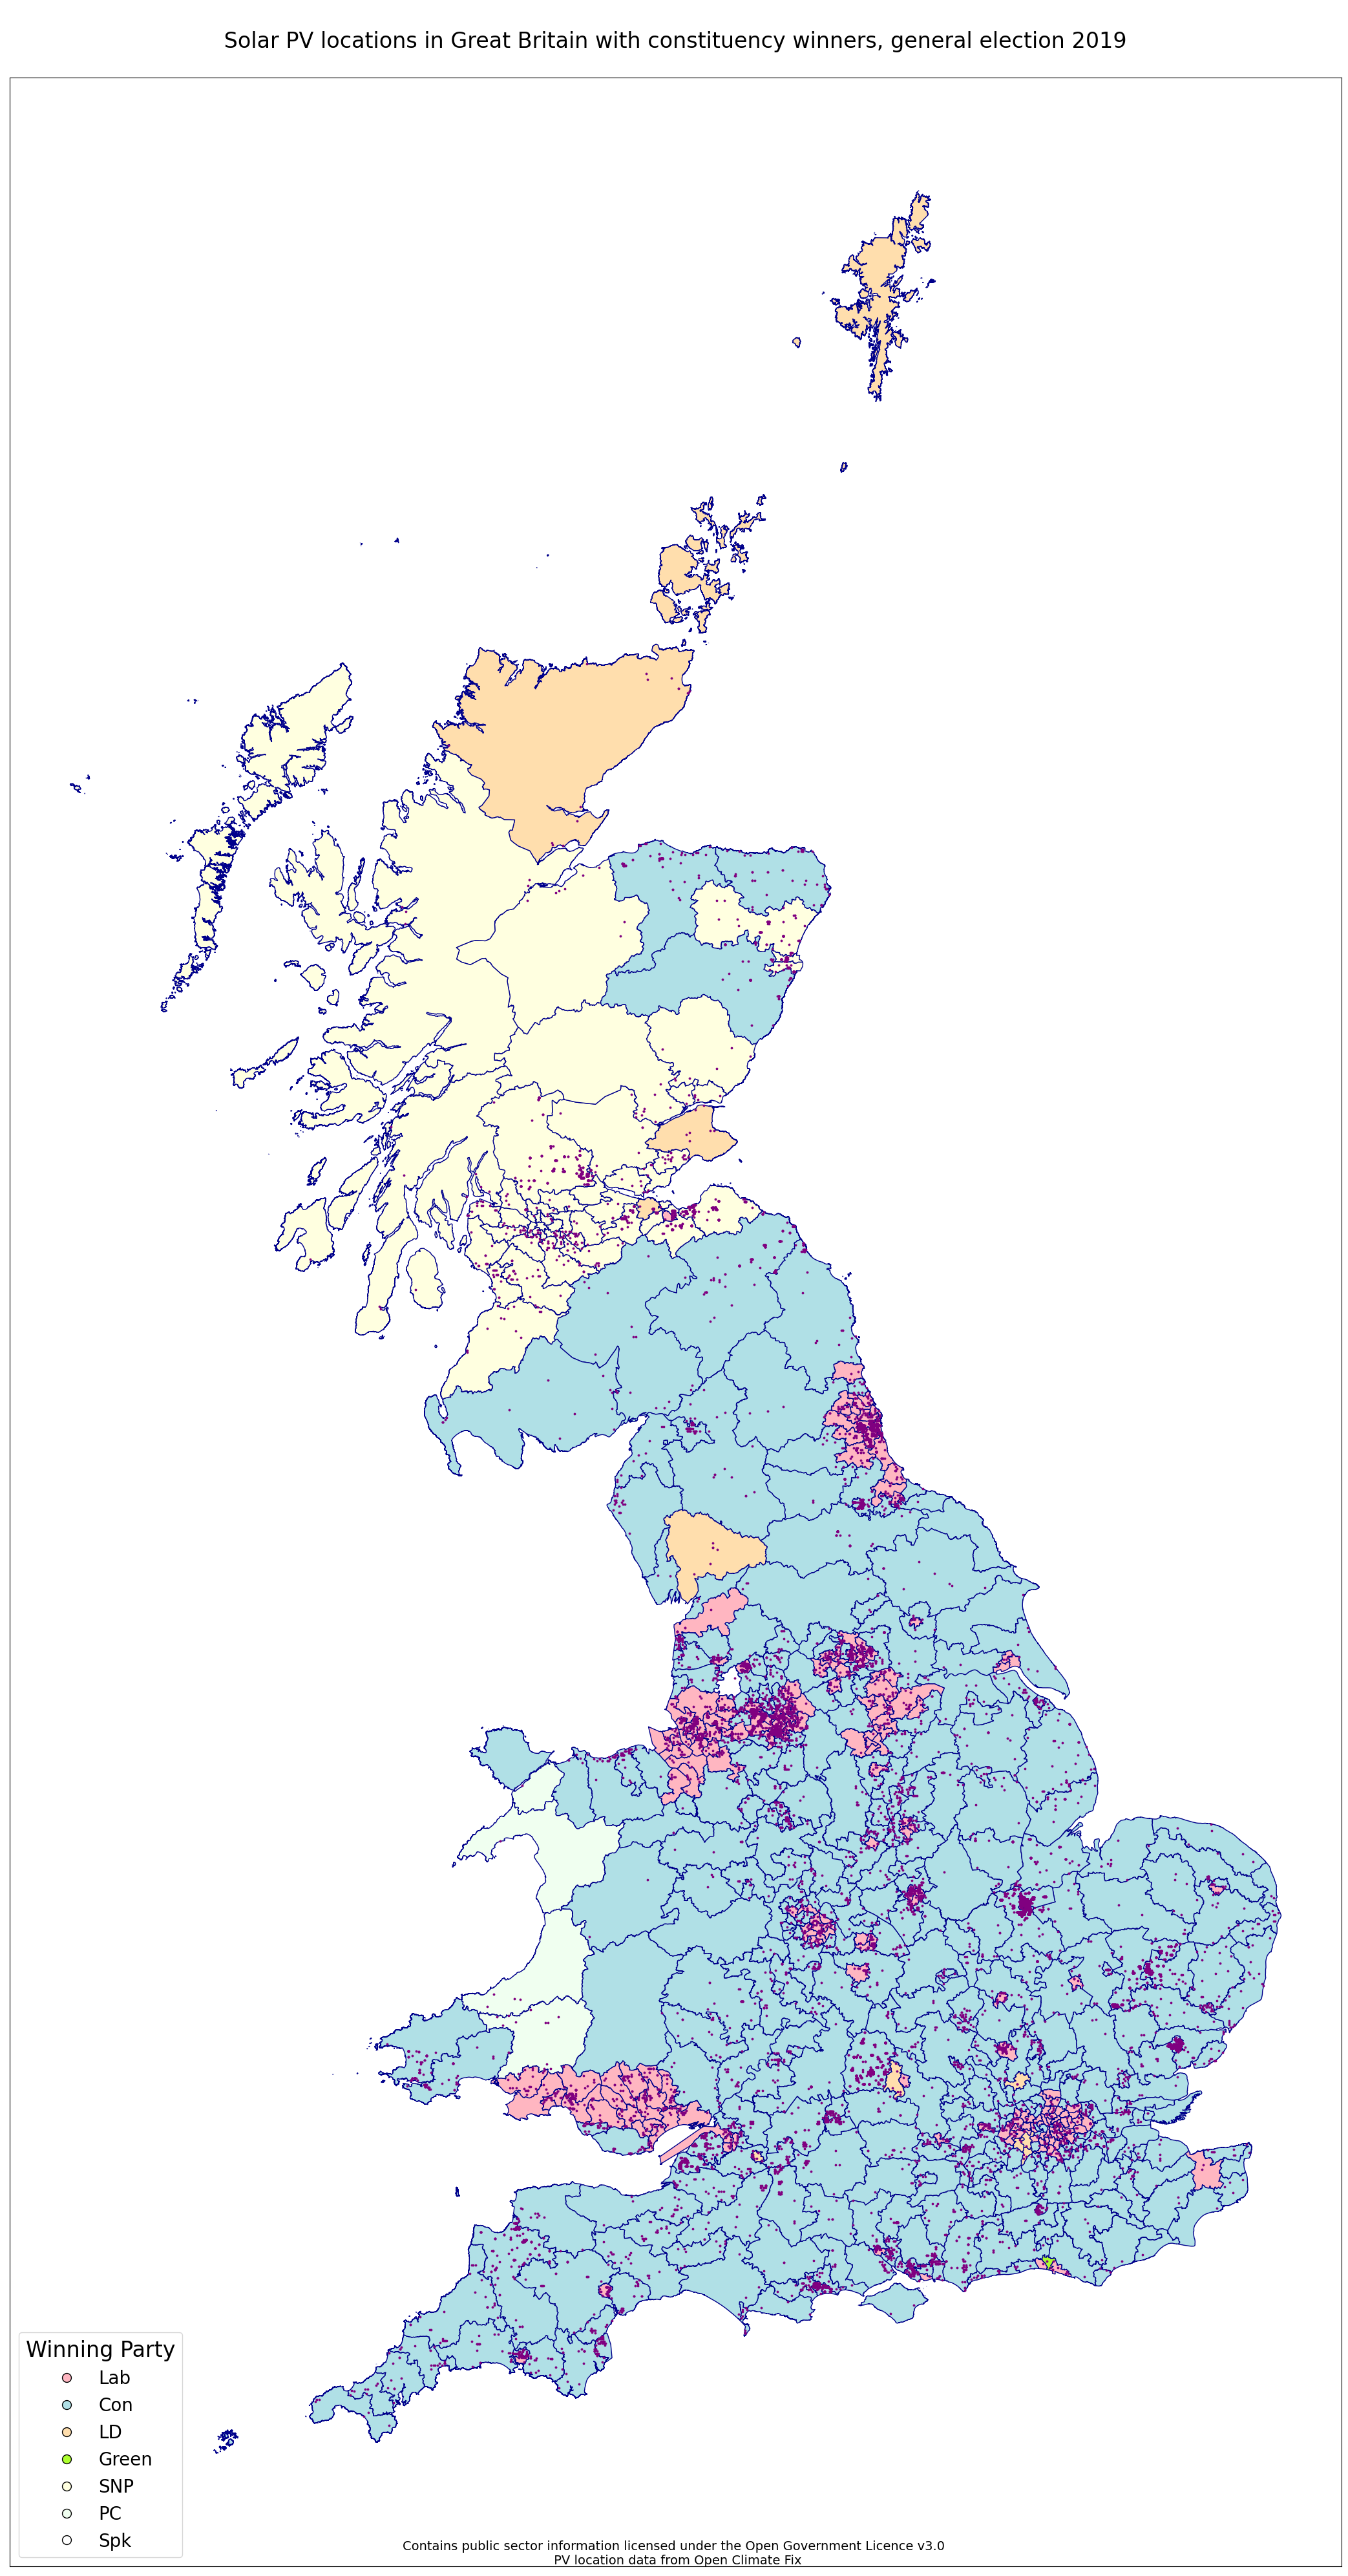

In [47]:

# Define the custom color mapping
party_colors = {
    'Lab': 'lightpink',
    'Con': 'powderblue',
    'LD': 'navajowhite',
    'Green': 'greenyellow',
    'SNP' :'lightyellow',
    'PC' : 'honeydew',
    'Spk' : 'white'
}

#Create a custom colormap using the party_colors dictionary
cmap = mcolors.ListedColormap([party_colors.get(x) for x in sorted(party_colors.keys())])

#Plot the constituencies with colors based on the winning party
fig, ax = plt.subplots(figsize=(50, 50))
combined.plot(column='first_party', legend=True, ax=ax, cmap=cmap, edgecolor='darkblue')

#Add the PV installations points on top of the constituencies
pv_constituencies.plot(markersize=3, color='purple', ax=ax)

#Set the axis to not display any ticks
ax.set_xticks([])
ax.set_yticks([])


legend_elements = [matplotlib.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor=party_colors[party], markeredgecolor= 'black', markersize=10, label=party) for party in party_colors]
ax.legend(handles=legend_elements, 
fontsize=20, loc='lower left', title='Winning Party', 
title_fontsize=24, )


main_title = '\n Solar PV locations in Great Britain with constituency winners, general election 2019 \n'
plt.title(main_title, fontsize=24)


label = 'Contains public sector information licensed under the Open Government Licence v3.0 \n PV location data from Open Climate Fix'
x_position = (plt.xlim()[1] - plt.xlim()[0]) / 2 + plt.xlim()[0]
y_position = plt.ylim()[0]
plt.text(x_position, y_position, label, ha='center', va='bottom', fontsize=14)

plt.show()

## Aggregate PV installations by political party
As the PV location data is only available for a subset of the total installations I use data from National Statistics for more precise calculations. First the percentage of total PV install each party has in its constituencies, then the number of installations per million population by party.

  first_party  pv_count  percentage
0         Con  693714.0   69.046948
1       Green     904.0    0.089977
2          LD   12832.0    1.277198
3         Lab  225595.0   22.453989
4          PC    8831.0    0.878970
5         SNP   60559.0    6.027576
6         Spk    2264.0    0.225341
1004699.0


Text(0.5, 1.0, '\n Percentage of GB solar PV installations in constituencies by winning party\n')

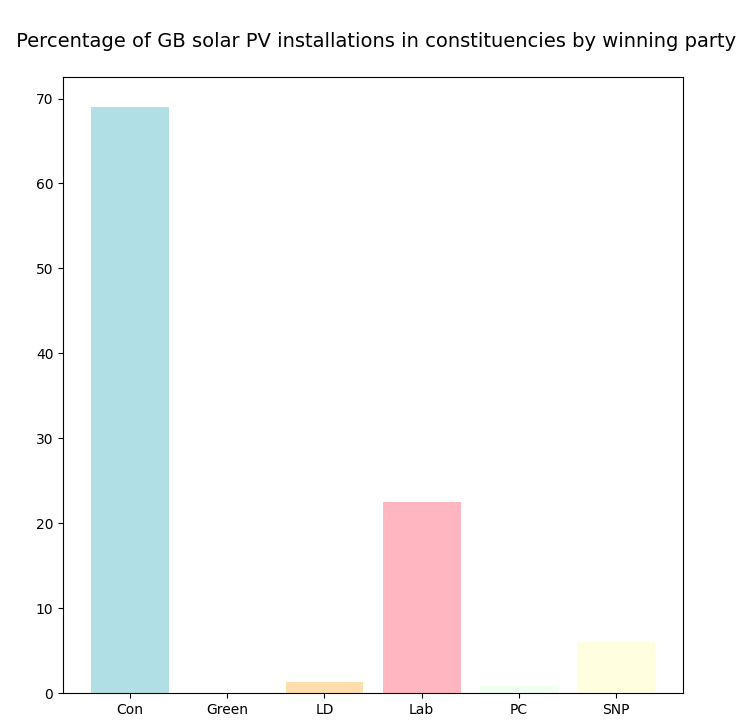

In [48]:
#Now calculate percentages of PV installs per party calculated using National Statistics information on numbers of
#solar installations by constituency. Only a subset of these have had their location recorded for mapping purposes.

ns_data = pd.read_excel('datasets/PV_deployment_by_PC_NS.xlsx')
ns_data = ns_data.rename(columns={'Constituency': 'NAME_x'})
ns_constituencies = pd.merge(combined, ns_data, on='NAME_x', how='left')

ns_data_counts = ns_constituencies.groupby('first_party')['Number of installations'].sum().reset_index(name='pv_count')
total_ns_data_count = ns_data_counts['pv_count'].sum()
ns_data_counts['percentage'] = ns_data_counts['pv_count'] / total_ns_data_count *100
print(ns_data_counts)
print(total_ns_data_count)

#Remove Speaker from chart as they are officially not a member of any party
ns_data_counts_filtered = ns_data_counts[ns_data_counts['first_party'] != 'Spk']
party_color_filtered = {
    'Lab': 'lightpink',
    'Con': 'powderblue',
    'LD': 'navajowhite',
    'Green': 'greenyellow',
    'SNP' :'lightyellow',
    'PC' : 'honeydew'
}

fig = plt.figure(figsize = (8,8))
plt.bar(ns_data_counts_filtered['first_party'], ns_data_counts_filtered['percentage'], color=[party_colors[p] for p in ns_data_counts_filtered['first_party']])

main_title = '\n Percentage of GB solar PV installations in constituencies by winning party\n'
plt.title(main_title, fontsize=14)



Text(0.5, 1.0, '\n Number of PV installations per million population in constituencies by winning party \n')

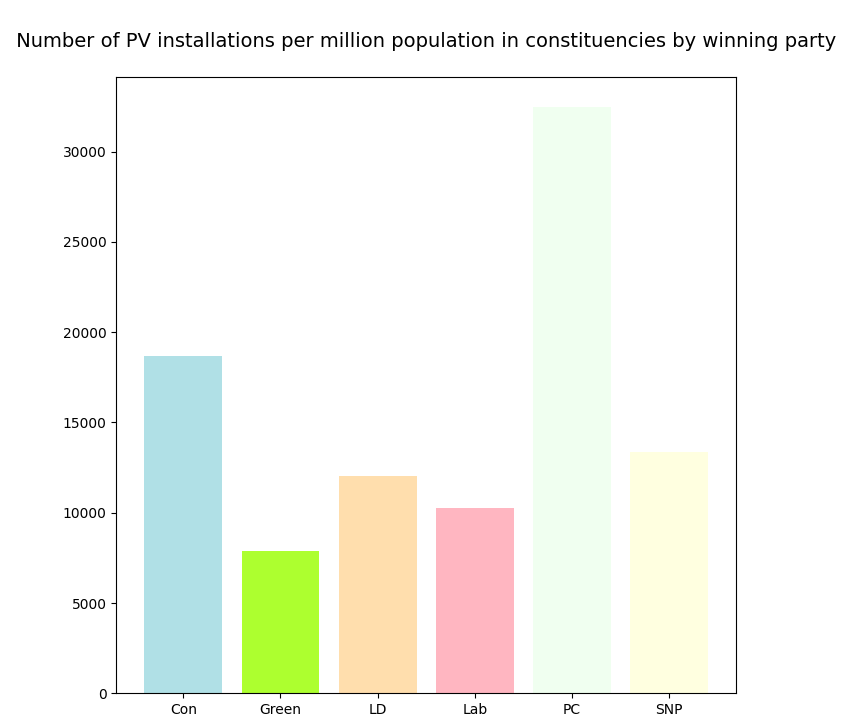

In [49]:
#Combine PV installations with population numbers to get per capita installation figures 

per_capita_combined = pd.merge(ns_data_counts, per_capita_counts, on='first_party', how='left')
per_capita_combined['pv_per_million_pop']=(per_capita_combined['pv_count']/per_capita_combined['pop_count']*1000000).astype(int)


# Remove Speaker from chart
per_capita_combined_filtered = per_capita_combined[per_capita_combined['first_party'] != 'Spk']
party_color_filtered = {
    'Lab': 'lightpink',
    'Con': 'powderblue',
    'LD': 'navajowhite',
    'Green': 'greenyellow',
    'SNP' :'lightyellow',
    'PC' : 'honeydew'
}

fig = plt.figure(figsize = (8,8))
plt.bar(per_capita_combined_filtered['first_party'], per_capita_combined_filtered['pv_per_million_pop'], color=[party_colors[p] for p in per_capita_combined_filtered['first_party']])

main_title = '\n Number of PV installations per million population in constituencies by winning party \n'
plt.title(main_title, fontsize=14)


57% of voters who owned their home outright voted Conservative, as did 43% of people with mortgages. The Conservative party got a vote share of 43.6% (House of Commons Library - https://commonslibrary.parliament.uk/ge2019-how-did-demographics-affect-the-result/)

Ditching Net Zero is a vote-loser for the Conservatives:

Nearly half (46%) of voters say they would be less likely to vote for a party that pledged to get rid of the Net Zero target. Only 15% say it would make them more likely to vote for such a party. (https://www.ukonward.com/reports/taking-the-temperature/)


Solar photovoltaic sites in the United Kingdom numbered 1,133,645 by the end of 2021. Following commercial distribution in 2007, installations boomed between 2009 and 2014. With the market becoming more competitive, installation costs have fallen in recent years. Prices for small scale solar PV systems oscillated between 1,165 and 2,000 British pounds per kilowatt as of May 2022. (https://www.statista.com/statistics/418830/number-of-solar-photovoltaic-installations-uk/)

58% of people intending to vote Conservative at the next election want to see more renewables deployed to bring down bills. (https://www.wearepossible.org/latest-news/conservative-voters-want-more-renewable-energy) 15/03/23